# Twitter Topic Analysis

I created a list of tweets from Twitter and the mission is to identify the topics accurately. The goal is to validate how accurate these identified topics are.

> Analyzing the results and detailing the findings.



### Insert Dataset from Google Drive

Before starting the validation process, let's first insert the dataset containing the tweets and their corresponding topics.

In [1]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

# Define the destination folder in Google Drive
folder_path = '/content/drive/My Drive/ColabFiles/twitter-topic-modeling/'

Mounted at /content/drive


In [21]:
import pandas as pd

# Load the CSV file
file_path = 'dataset.csv'
data = pd.read_csv(folder_path + file_path)

# Rename the column
data = data.rename(columns={'Lemmatized Cleaned Text': 'text'})

# Select the columns in the desired order
data = data[['text', 'topic_id', 'topic']]

data.sample(100)

,text,topic_id,topic
1433,התברר פטריוט מדינה מושיע יושב מרום לפחות קריאה...,H,Civil-Military Relations in Israel
329,אישה סטרוק בושה אנושות לא ראוי היי שרה ממשלה ת...,K,Public Opinion on Political Leadership
2983,נתניהו מסרב התמודד שאלה יום אחרי היי יום אחרי ...,D,Political Accountability in Israel
2369,מאוד העריך כתיבה דעה פעם תוהה קשר מועד נקבע מר...,D,Political Accountability in Israel
2506,מחילה התנהלות מתנגד נתניהו מתנהל הפקרות מוחלט ...,D,Political Accountability in Israel
...,...,...,...
45,אוכלוסייה העזתי שליטה ישראל אז ב איך חייל אמור...,O,Impact of Military Actions on Civilian Life
2093,כוח הפיל מסוק נוסף רגע מסוק התרסק קרקע כוח מיה...,A,Military Operations in Gaza
2536,מי שכח הן נתניהו מתווה סולברג מומצא סולברג הבה...,I,Impact of Supreme Court Decisions on Governance
2742,מריח מקבל החלטה מערכה ביטחון יום כניסה קרקעית ...,A,Military Operations in Gaza


### 1) Distribution of Topics w/ GPT-4o

- In the previous notebook, I processed each tweet using GPT-4o to identify potential topic for each tweet.
- Each tweet was assigned a topic by the LLM.
- To validate, I plotted a graph showing the distribution of topics among the tweets. If the topics are evenly distributed, it indicates a good representation.

In [4]:
data[['topic_id', 'topic']].value_counts(dropna=False)

topic_id  topic                                          
A         Military Operations in Gaza                        731
I         Impact of Supreme Court Decisions on Governance    707
D         Political Accountability in Israel                 560
Q         Public Opinion on Judicial Reform                  346
B         Judicial Reform and its Implications               333
H         Civil-Military Relations in Israel                 330
K         Public Opinion on Political Leadership             326
O         Impact of Military Actions on Civilian Life        226
NaN       NaN                                                200
C         Public Sentiment on Government Policies            195
G         Public Protests Against Government Actions         188
F         Media Representation of War Events                 175
Name: count, dtype: int64

![pic](https://drive.google.com/uc?id=1VPzaathLzS0y0YYzcG4jbVEL_wrRVE8u)

I did a further step, and provided GPT-4o the graph and the mission I tried to solve:

#### GPT Analysis:

1. **Focus Areas**:
   - The high counts for **Military Operations in Gaza** and **Impact of Supreme Court Decisions on Governance** suggest <mark>these are critical issues</mark>. Efforts could be focused on understanding the nuances of public sentiment in these areas.

2. **Moderate Attention Topics**:
   - Topics like **Political Accountability** and **Judicial Reform** should also be closely monitored, as they represent significant public interest.

3. **Underrepresented Topics**:
   - For topics with fewer tweets, such as **Media Representation of War Events**, <mark>consider whether these are niche topics or if the data collection methods could be missing relevant tweets</mark>.
   - The 200 unassigned tweets need attention to understand why they were not categorized. Manual review or refinement of the topic classification model may be required. <mark>My addition: it's just spam.</mark>

4. **Balanced Representation**:
   - To ensure a balanced understanding, consider further analysis or data collection for underrepresented topics.
   - Investigate if the distribution reflects real-world importance or if it is skewed due to data collection or model biases.

5. **Refinement and Validation**:
   - Validate the topic classification by <mark>comparing with human annotations or using alternative models</mark>.
   - Continuously refine the topic classification process to reduce the number of unassigned tweets and ensure more accurate topic assignments.

It looks like the GPT model acts awesomely and helped us in getting insights on the topics we generated before.

Given its key insights, we can do some prompt engineering and make the LLMs generate topics that are evenly distributed.

Another point of view: we can use a dataset from Facebook or English tweets, and see the distribution. If we see the same distribution, we will understand that we got a good result.

### 2) Clustering Validation

- Apply clustering algorithms (e.g., K-means, DBSCAN) to the tweet embeddings.
- Compare the clusters formed by these algorithms with the topics assigned by the language model.
- Calculate cluster purity or Adjusted Rand Index (ARI) to measure similarity.

In [24]:
import requests
import numpy as np
from google.colab import userdata

class OpenAIEmbeddingProcessor:
    def __init__(self, model="text-embedding-3-large"):
        self.api_key = userdata.get('OPENAI_API_KEY')
        if not self.api_key:
            raise ValueError("API key is not set. Please set the OPENAI_API_KEY environment variable.")
        self.model = model

    def get_embeddings(self, text):
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.api_key}",
        }
        data = {
            "input": text,
            "model": self.model
        }
        response = requests.post("https://api.openai.com/v1/embeddings", headers=headers, json=data)
        response.raise_for_status()  # Raise an error for bad responses
        return response.json()

    def normalize_l2(self, x):
        x = np.array(x)
        if x.ndim == 1:
            norm = np.linalg.norm(x)
            if norm == 0:
                return x
            return x / norm
        else:
            norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
            return np.where(norm == 0, x, x / norm)

    def process_text(self, text):
        response = self.get_embeddings(text)
        embedding = response['data'][0]['embedding']
        cut_dim = embedding[:256]
        norm_dim = self.normalize_l2(cut_dim)
        return norm_dim

# Example usage:
processor = OpenAIEmbeddingProcessor()
normalized_embedding = processor.process_text("Testing 123")
print(normalized_embedding[:10])

[-0.04393171  0.0217387  -0.01184612  0.07991301 -0.05851505  0.01311818
 -0.03852543  0.17818013  0.01587811 -0.035686  ]


In [30]:
import pandas as pd
from multiprocessing import Pool
from tqdm import tqdm

# Initialize the processor
processor = OpenAIEmbeddingProcessor()

# Function to process text and return embedding
def get_embedding(text):
    return processor.process_text(text)

# Number of parallel processes
num_processes = 32

if __name__ == '__main__':
    # Wrap the pool.map call with tqdm for a progress bar
    with Pool(num_processes) as pool:
        embeddings = list(tqdm(pool.imap(get_embedding, data['text']), total=len(data)))

    # Add the embeddings to the DataFrame
    data['embedding'] = embeddings

100%|██████████| 4317/4317 [07:13<00:00,  9.95it/s]


In [33]:
# Save or use the DataFrame as needed
data.to_csv(folder_path + 'dataset_embed.csv', index=False)

# Display the DataFrame with embeddings
data.head(1)

,text,topic_id,topic,embedding
0,א התפלא נלחם רגע ב הזכיר רגע זמן הוא יוצא מגדר...,K,Public Opinion on Political Leadership,"[0.038320791777968634, 0.036041488300321556, -..."


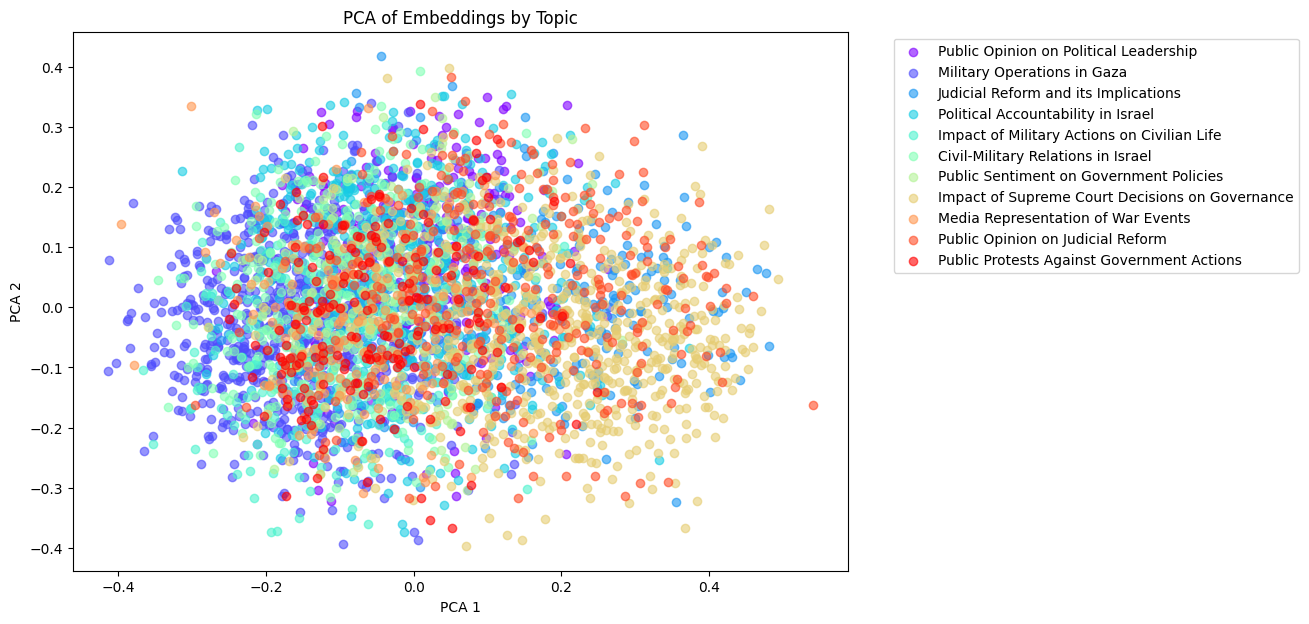

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Remove rows where 'topic' is NaN
df = data.dropna(subset=['topic']).copy()

# Perform PCA on the embeddings
pca = PCA(n_components=2)
embeddings = np.array(df['embedding'].tolist())
pca_result = pca.fit_transform(embeddings)

# Add the PCA results to the DataFrame
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Plot the PCA results
plt.figure(figsize=(10, 7))

# Get unique topics
topics = df['topic'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(topics)))

for topic, color in zip(topics, colors):
    indices = df['topic'] == topic
    plt.scatter(df.loc[indices, 'pca_1'], df.loc[indices, 'pca_2'], label=topic, color=color, alpha=0.6)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Embeddings by Topic')

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

The PCA process reduces the number of dimensions of each vector (after I reduced it to 256) to 2 vectors, which we can see and understand visually.

From the graph, we can see that there are topics that are indeed close in semantic terms, indicating that we have successfully classified them well. There are also topics that overlap. This doesn't necessarily mean they are not good; rather, it shows that their meanings are close according to this Embedding model.

It's important to note that there are doubts about using PCA, but I like it because it visually presents things that are sometimes difficult to understand.

### 3) Semantic Similarity

Calculate the semantic similarity between tweets within the same topic.
High average similarity scores suggest that tweets grouped under the same topic are semantically coherent.


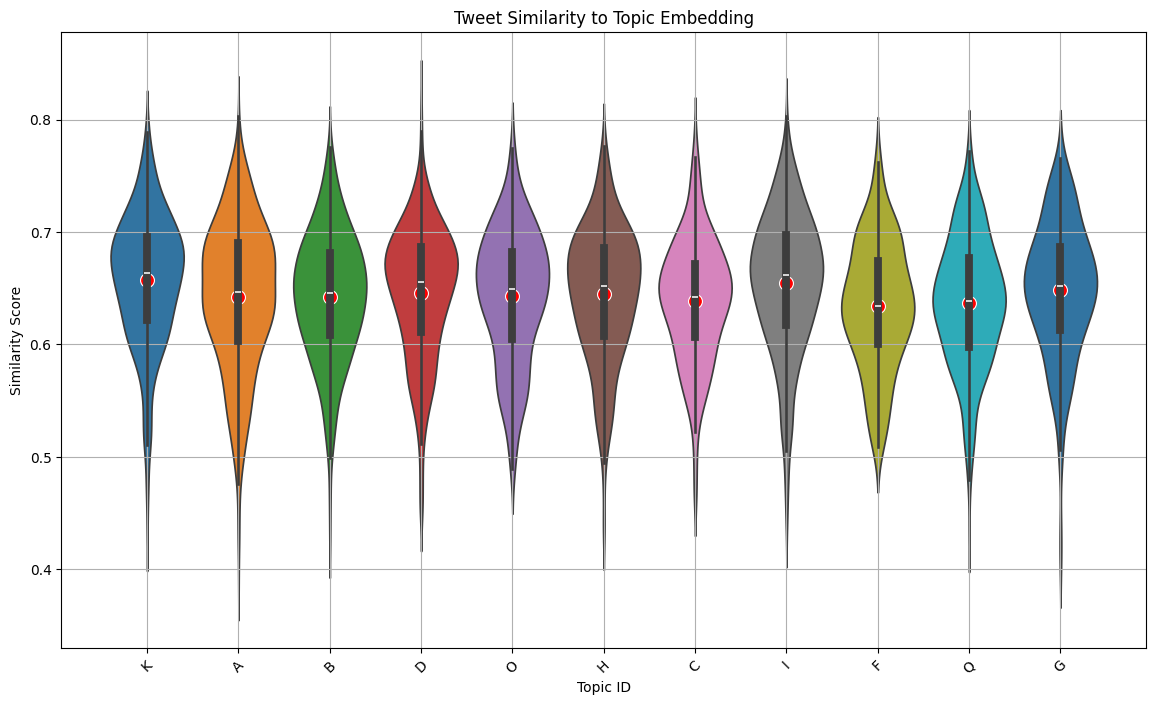

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate average embedding for each topic
def calculate_topic_embeddings(data):
    topic_embeddings = {}
    for topic_id in data['topic_id'].unique():
        topic_data = data[data['topic_id'] == topic_id]
        if not topic_data['embedding'].empty:
            avg_embedding = np.mean(np.stack(topic_data['embedding'].values), axis=0)
            topic_embeddings[topic_id] = avg_embedding
    return topic_embeddings

# Calculate topic embeddings
topic_embeddings = calculate_topic_embeddings(data)

# Function to calculate similarity scores
def calculate_similarity_scores(data, topic_embeddings):
    similarity_scores = []
    for index, row in data.iterrows():
        if pd.isna(row['topic_id']) or row['topic_id'] not in topic_embeddings or pd.isna(row['embedding']).any():
            similarity_scores.append(np.nan)
            continue
        tweet_embedding = row['embedding']
        topic_embedding = topic_embeddings[row['topic_id']]
        similarity = cosine_similarity([tweet_embedding], [topic_embedding])[0][0]
        similarity_scores.append(similarity)
    return similarity_scores

# Calculate similarity scores
data['similarity_score'] = calculate_similarity_scores(data, topic_embeddings)

# Calculate average similarity score for each topic
average_similarity_scores = data.groupby('topic_id')['similarity_score'].mean().reset_index()
average_similarity_scores.columns = ['topic_id', 'average_similarity_score']

# Merge average similarity scores back into the main dataframe for plotting
data = pd.merge(data, average_similarity_scores, on='topic_id', how='left')

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='topic_id', y='similarity_score', data=data, hue='topic_id', palette='tab10', legend=False)

# Plot average similarity scores as points
sns.scatterplot(x='topic_id', y='average_similarity_score', data=average_similarity_scores, color='red', s=100, marker='o')

plt.title('Tweet Similarity to Topic Embedding')
plt.xlabel('Topic ID')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### GPT Powered Insights Once Again

The violin plot illustrates the distribution of similarity scores for tweets within each topic. Here are some key takeaways:

1. **Distribution and Central Tendency**:
   - The width of each violin indicates the density of tweets with certain similarity scores.
   - The black bar in each violin shows the interquartile range (IQR), and the white dot represents the median similarity score.
   - The red dots represent the average similarity scores for each topic.

2. **Topic Coherence**:
   - Most topics have <mark>median similarity scores around 0.65, suggesting a reasonable level of coherence</mark>.
   - Topics with narrow IQRs and red dots close to the median indicate higher coherence, meaning tweets within these topics are semantically similar.

### Evaluation of Topics:
The following topics have more variability in similarity scores and may need to be refined to improve coherence:

- **A (Military Operations in Gaza)**: High density and good coherence, but review for any outliers.
- **I (Impact of Supreme Court Decisions on Governance)**: Generally good coherence but ensure all tweets fit well.
- **D (Political Accountability in Israel)**: More variability, suggesting a need for refinement.
- **Q (Public Opinion on Judicial Reform)**: High variability, indicating diverse tweet content within the topic.
- **O (Impact of Military Actions on Civilian Life)**: Moderate coherence, may benefit from further refinement.
- **C (Public Sentiment on Government Policies)**: Higher variability, suggesting the need for better topic definition.

### Conclusion:

Overall, the graph shows that the <mark>topics are reasonably coherent, with most tweets within each topic having similar semantic content</mark>. However, some topics, particularly **D**, **Q**, **O**, and **C**, display higher variability and <mark>may require refinement</mark> to improve their coherence.

### Next Steps:

1. **Refine Topics**: Focus on redefining the boundaries for topics **D**, **Q**, **O**, and **C** to ensure higher semantic similarity among tweets.
2. **Analyze Outliers**: Investigate tweets with low similarity scores to understand their divergence and adjust topic definitions accordingly.
3. **Iterate and Improve**: Use the insights to iterate on the topic modeling process, enhancing the coherence of the topics.

## Summery

### Process Summary

0. **EDA**:
   - The first thing I did was to gather insights from the data with different kinds of simple processing and graphs.

1. **Data Preparation**:
   - I cleaned the data by removing frequently occurring words and performed lemmatization to normalize words to their base forms.

2. **Topic Modeling**:
   - I applied language models to generate a list of topics from the cleaned data.

3. **Classification**:
   - I classified several hundred tweets into the generated topics, creating a dataset of tweets and their associated topics.

4. **Validation**:
   - I used various validation methods to assess the accuracy of topic representation, finding an approximate representation accuracy of 65%.

### Improvement Suggestions
   - I plan to use a language model specifically trained for Hebrew to improve topic representation.
   - I would apply embeddings directly to tweets to identify similar ones without relying solely on classification.
   - I was considering fine-tuning BERT or similar models for more effective topic extraction and event identification.
   - And much much more :-)